In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy
import sklearn
import src.common as common
import src.ranking as ranking
import src.data_loading as data_loading
import src.data_transformation as data_transformation
import src.user_profile as user_profile
import src.test as test
import traceback


In [2]:
data_loader = data_loading.DataLoader('../data')
movies_df = data_loader.load_movies()
ratings_df = data_loader.load_ratings()

In [3]:
# split the data into train and test sets
train_set, test_set, test_user_ids = test.RankingTest.split_ratings_into_train_test(ratings_df.copy())
movie_rec_df = data_transformation.DataTransformer.transform_data(movies_df.copy(), train_set)
results = []
# i = 0
# user_profiles = user_profile.UserProfileCreator.build_user_profiles(movie_rec_df, train_set)
# user_profiles.head()
# for user_id in sorted(test_user_ids):
#     try:
#         user_ratings = test_set[test_set['userId'] == user_id]
#         train_user_ratings, test_user_ratings = test.RankingTest.split_user_ratings(user_ratings, n=0.1, k=10)
#         test_user_profile = user_profile.UserProfileCreator.build_user_profile(movie_rec_df, train_user_ratings)
#         ranking_df = ranking.RankingCreator.create_ranking(test_user_profile, movie_rec_df)
#         # filter ranking_df so that it only includes movie_id from test user ratings
#         test_movie_ids = test_user_ratings['movieId'].unique()
#         filtered_ranking_df = ranking_df[ranking_df.index.isin(test_movie_ids)]
#         results.append(test.RankingTest.calculate_spearman_corr(test_user_ratings.sort_values(by='rating', ascending=False), filtered_ranking_df))
#         i+=1
#         if i == 1000:
#             break
#     except Exception as e:
#         print(f"Error processing user {user_id}: {e}")
#         print(traceback.format_exc())
#         continue

In [14]:
from src.models import AprioriKmeansRecommender

model = AprioriKmeansRecommender(movie_rec_df, min_support=0.1, k=21, min_confidence=0.1)
model.fit(train_set)
model.get_rules()


{0:             antecedents          consequents  antecedent support  \
 0              (Action)          (Adventure)            0.497227   
 1           (Adventure)             (Action)            0.342562   
 2              (Action)             (Sci-Fi)            0.497227   
 3              (Sci-Fi)             (Action)            0.550551   
 4            (Thriller)             (Action)            0.380546   
 5              (Action)           (Thriller)            0.497227   
 6              (Sci-Fi)          (Adventure)            0.550551   
 7           (Adventure)             (Sci-Fi)            0.342562   
 8               (Drama)             (Sci-Fi)            0.330006   
 9              (Sci-Fi)              (Drama)            0.550551   
 10           (Thriller)              (Drama)            0.380546   
 11              (Drama)           (Thriller)            0.330006   
 12           (Thriller)             (Sci-Fi)            0.380546   
 13             (Sci-Fi)       

In [17]:
test_user_ratings = test_set[test_set['userId'] == min(test_user_ids[test_user_ids != 0])]
recommendations = model.recommend_for_user(test_user_ratings, top_n=10)

User cluster: 17


C:\Data\Studia\magisterka\semestr_8\data-mining-project\.venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


In [18]:
movies_df[movies_df['movieId'].isin(recommendations)]

,movieId,title,genres
454,459,"Getaway, The (1994)",Action|Adventure|Crime|Drama|Romance|Thriller
514,519,RoboCop 3 (1993),Action|Crime|Drama|Sci-Fi|Thriller
11240,49530,Blood Diamond (2006),Action|Adventure|Crime|Drama|Thriller|War
15392,81132,Rubber (2010),Action|Adventure|Comedy|Crime|Drama|Film-Noir|...
20497,105974,Assault on a Queen (1966),Action|Adventure|Crime|Drama|Thriller
22565,115479,"Whip Hand, The (1951)",Action|Adventure|Crime|Drama|Sci-Fi|Thriller|War
25042,122787,The 39 Steps (1959),Action|Adventure|Comedy|Crime|Drama|Thriller
34202,144324,Once Upon a Time (2008),Action|Adventure|Comedy|Crime|Drama|Romance|Th...
49995,178865,I Witness (2003),Action|Adventure|Crime|Drama|Mystery|Thriller
76169,251660,Erica (2019),Action|Adventure|Crime|Drama|Horror|Mystery|Th...


In [24]:
results = [res if not np.isnan(res) else 0 for res in results ]
print(results)
print(f"Mean NDCG: {np.mean(results)}")
print(f"Standard Deviation NDCG: {np.std(results)}")


[np.float64(0.6860571089196594), np.float64(-0.01297498240269205), np.float64(-0.12349650381112376), np.float64(0.07237468644557458), np.float64(0.5148232810904031), np.float64(0.37877700953928506), np.float64(0.10699444587365947), np.float64(0.4671457034214359), np.float64(0.5415386082446842), np.float64(0.20412414523193154), np.float64(-0.18422647458873528), np.float64(0.2195663143362036), np.float64(0.42870375986597026), np.float64(0.49760066534670505), np.float64(0.1859910555043518), np.float64(0.345643126531901), np.float64(0.2472066162365221), np.float64(-0.24253732318886512), np.float64(0.16414505016140593), np.float64(0.18019071590012917), np.float64(0.5912866770718964), np.float64(-0.01946247360403807), np.float64(0.34151450937027694), np.float64(0.32741472132289046), np.float64(-0.10815649964574403), np.float64(0.5127504275741923), np.float64(0.09380352942419311), np.float64(-0.45905523340560367), np.float64(0.44263134656228503), np.float64(-0.019069251784911846), np.float64(

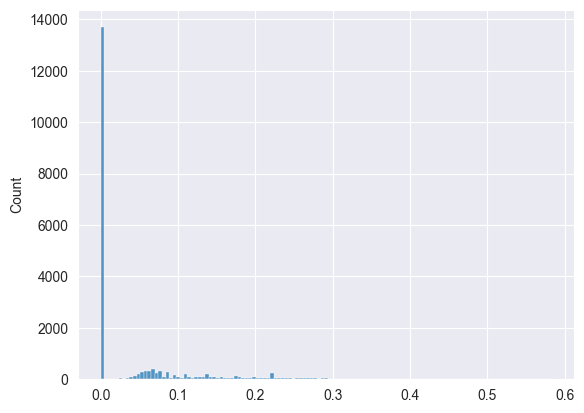

In [5]:
sns.histplot(results)
plt.show()